# Training a classifier

We first import everything we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nn import io, nn, preprocess

We then read in the data and take substrings of the negative examples so the lengths match.

In [2]:
# Read in raw data
positives = io.read_text_file("data/rap1-lieb-positives.txt")
raw_negatives = io.read_fasta_file("data/yeast-upstream-1k-negative.fa")

# Shorten the negative examples
target_len = len(positives[0])
negatives = []
for s in raw_negatives:
    negatives += [s[target_len * i:target_len * (i + 1)] for i in range(len(s) // target_len)]
    
# Combine and create labels
seqs = positives + negatives
labels = [True] * len(positives) + [False] * len(negatives)

# Print counts
print(f"Number of positive examples: {len(positives)}")
print(f"Number of negative examples: {len(negatives)}")

Number of positive examples: 137
Number of negative examples: 183297


To solve the class imbalance, I implemented an oversampling scheme where positive examples are sampled with replacement until the classes are balanced. I could also have undersampled the negative examples, but in this case that would likely have made the dataset too small to be useful.

In [3]:
seqs, labels = preprocess.sample_seqs(seqs, labels)

We can then one-hot encode the sequences and split them into training and validation sets.

In [4]:
X = preprocess.one_hot_encode_seqs(seqs)
X_train, X_val, y_train, y_val = train_test_split(X, np.array(labels), test_size = 0.2, random_state = 0)
print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Training shape: (293275, 68)
Validation shape: (73319, 68)


Finally, we create and train the neural network, plotting the loss over training and calculating the final accuracy on the validation dataset.

Finished epoch 1 of 20.
Final accuracy on validation set: 0.9993862436749001


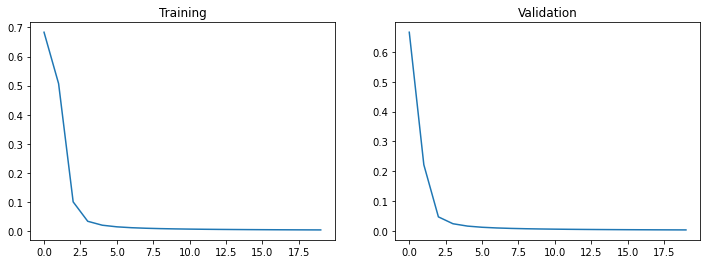

In [5]:
# Create network
layers = [{"input_dim": 68, "output_dim": 34, "activation": "sigmoid"},
          {"input_dim": 34, "output_dim": 17, "activation": "sigmoid"},
          {"input_dim": 17, "output_dim": 1, "activation": "sigmoid"},]
net = nn.NeuralNetwork(layers, lr = 0.01, seed = 42, batch_size = 100, epochs = 20, loss_function = "bce")

# Reshape 1D arrays to 2D so the dimensions work
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# Train
train_losses, val_losses = net.fit(X_train, y_train, X_val, y_val)

# Plot losses
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(range(20), train_losses)
ax[0].set_title("Training")
ax[1].plot(range(20), val_losses)
ax[1].set_title("Validation")

# Compute accuracy
pred = (net.predict(X_val) >= 0.5).astype(int)
print(f"Final accuracy on validation set: {np.sum(pred == y_val) / len(y_val)}")

I chose the sigmoid activation function and binary cross-entropy loss since both are well-suited to binary classification tasks like this one. The architecture of the network was somewhat arbitrary -- reducing the number of nodes by a factor of two at each layer is something I've seen a lot in the feedforward section of convolutional neural network classifiers, so I just followed that pattern here and it seemed to work. I started with the hyperparameters from the autoencoder and noticed that the convergence was much slower, so I increased the learning rate and decreased the number of epochs until I thought it felt reasonable.